병렬 처리를 위한 효율 개선
- 특정 로직이 주어졌을 때, 두 개의 브랜치(노드 및 서브그래프)로 양분
- 기존 방식에는 하나의 분기로 움직이는 시퀀스
- 그러나, 해당 방식은 양분하는 병렬 처리 방식으로 시간 절약

<img src="/Users/seonghoe/인프런_랭그래프/lecture./langgraph/병렬처리_도식화.png">

In [69]:
from dotenv import load_dotenv

load_dotenv()

True

In [70]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    answer: str # 세율
    # 우리에게 필요한 노드는 아래와 같음. (+ 이들에 대한 State 정의)
    tax_base_equation: str  # 과세표준 게산 수식
    tax_deduction: str  # 공제액 
    market_ratio: str   # 공정시장가액비율
    tax_base: str   # 과세표준 계산

graph_builder = StateGraph(AgentState)

환경변수 설정 및 STATE 정의 완료

과세표준 계산 수식 노드 생성 (→ 벡터 DB 내 존재)

In [71]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name='real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [72]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [73]:
from langchain_openai import ChatOpenAI
from langchain import hub

rag_prompt = hub.pull('rlm/rag-prompt')
llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [74]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

# 리트리빙을 위한 체인
tax_base_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요.'),
    ('human', '{tax_base_equation_information}')
])

# 결과를 수식으로 변환히기 위한 체인
tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()

)   

tax_base_chain = {'tax_base_equation_information': tax_base_retrieval_chain} | tax_base_equation_chain
 
def get_tax_base_equation(state: AgentState): 
    tax_base_equation_question = '주택에 대한 종합부동산세 게산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation': tax_base_equation}

RunnableMap({"context": retriever, "question": RunnablePassthrough()})
- context = retriever.invoke(input)
- question = input
- RunnablePassthrough = '입력을 가공하지 않고 그대로 다음 단계로 넘기기 위한 장치'

In [75]:
get_tax_base_equation({})
# {'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율'}

{'tax_base_equation': '(주택 공시가격 합계 - 공제 금액) × 공정시장가액비율'}

공제액 노드 생성 

In [76]:
tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState): 
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요.'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction':  tax_deduction}

In [77]:
get_tax_deduction({})
# {'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원입니다. 법인 또는 법인으로 보는 단체의 경우 6억 원, 그 외의 경우는 9억 원이 공제됩니다.'}

{'tax_deduction': '주택에 대한 종합부동산세 계산 시 1세대 1주택자는 12억 원, 법인이나 법인으로 보는 단체는 6억 원, 그 외의 경우는 9억 원을 공제합니다.'}

공정시장가액비율 노드 생성 (→웹 서치)

In [78]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=7,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 사용자의 질문에 답변해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇 % 인가요?'
    context = tavily_search_tool.invoke(query)
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm 
        | StrOutputParser()
    )
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    return {'market_ratio': market_ratio}

In [79]:
get_market_ratio({})
# {'market_ratio': '2026년 기준으로 주택의 공정시장가액비율은 60%입니다.'}

{'market_ratio': '2026년 주택 공시가격에 대한 공정시장가액비율은 60%입니다. 2025년부터 한시적으로 낮췄던 비율이 종료되고 다시 법정 수준인 60%로 되돌아갔습니다.'}

과세 표준 계산

In [ ]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = ChatPromptTemplate.from_messages("""
주어진 내용을 기반으로 과세표준을 계산해주세요.
                                                                                                                                                   
과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}                                                                                                                             
사용자 주택 공시가격 정보: {query} 
                                                           
*주의사항*
- LaTeX, 수식 기호(\\, [, ], \(, \), \[, \]) 사용 금지
- 순수한 일반 텍스트로만 출력
- 특수기호 없이 숫자와 일반 괄호만 사용                               
""")

def calculate_tax_base(state: AgentState):
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })

    print(f'tax_base == {tax_base}')
    return{'tax_base': tax_base}

<>:3: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\('
/var/folders/hq/rb1q4rn512qbbsyy87bd4g9c0000gn/T/ipykernel_53832/1843125074.py:3: SyntaxWarning: invalid escape sequence '\('
  tax_base_calculation_prompt = PromptTemplate.from_template("""


In [87]:
initial_state = {
    'query': query,
    'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율',
    'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원입니다. 법인 또는 법인으로 보는 단체의 경우 6억 원, 그 외의 경우는 9억 원이 공제됩니다.',
    'market_ratio': '2026년 기준으로 주택의 공정시장가액비율은 60%입니다.'
}

In [88]:
calculate_tax_base(initial_state)

tax_base == 주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.

1. 주택의 공시가격 합계를 계산합니다:
   5억 (1채) + 10억 (1채) + 20억 (1채) = 35억 원

2. 과세표준 계산을 위한 공제금액을 결정합니다. 
   1세대 1주택자가 아닌 경우 공제금액은 9억 원입니다.

3. 공정시장가액비율을 적용합니다. 2026년 기준으로 공정시장가액비율은 60%입니다.

따라서 과세표준은 다음과 같이 계산됩니다:

과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율
과세표준 = (35억 - 9억) × 0.6
과세표준 = 26억 × 0.6
과세표준 = 15.6억 원

결론적으로, 과세표준은 15.6억 원입니다.


{'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. 주택의 공시가격 합계를 계산합니다:\n   5억 (1채) + 10억 (1채) + 20억 (1채) = 35억 원\n\n2. 과세표준 계산을 위한 공제금액을 결정합니다. \n   1세대 1주택자가 아닌 경우 공제금액은 9억 원입니다.\n\n3. 공정시장가액비율을 적용합니다. 2026년 기준으로 공정시장가액비율은 60%입니다.\n\n따라서 과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율\n과세표준 = (35억 - 9억) × 0.6\n과세표준 = 26억 × 0.6\n과세표준 = 15.6억 원\n\n결론적으로, 과세표준은 15.6억 원입니다.'}

세율 계산

<img src="/Users/seonghoe/인프런_랭그래프/lecture./langgraph/세율계산_도식화.png">

In [89]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요.
종합부동산세 세율:{context}'''),
    
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요.
과세표준: {tax_base}
주택 수: {query}''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        'context': context,
        'tax_base': tax_base,
        'query': query
    })
    
    print(f'tax_rate == {tax_rate}')
    return {'answer': tax_rate}

In [90]:
calculate_tax_base(initial_state)

tax_base == 사용자가 보유한 주택의 공시가격 합계는 다음과 같이 계산됩니다.

5억 원짜리 집 1채 + 10억 원짜리 집 1채 + 20억 원짜리 집 1채 = 35억 원

주어진 정보에 따르면, 사용자가 1세대 1주택자인지 여부는 명시되어 있지 않으므로 일반적인 경우로 가정하겠습니다. 따라서 공제금액은 9억 원입니다.

과세표준은 다음과 같이 계산됩니다.

과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율

과세표준 = (35억 원 - 9억 원) × 0.6

과세표준 = 26억 원 × 0.6

과세표준 = 15.6억 원

따라서 과세표준은 15.6억 원입니다.


{'tax_base': '사용자가 보유한 주택의 공시가격 합계는 다음과 같이 계산됩니다.\n\n5억 원짜리 집 1채 + 10억 원짜리 집 1채 + 20억 원짜리 집 1채 = 35억 원\n\n주어진 정보에 따르면, 사용자가 1세대 1주택자인지 여부는 명시되어 있지 않으므로 일반적인 경우로 가정하겠습니다. 따라서 공제금액은 9억 원입니다.\n\n과세표준은 다음과 같이 계산됩니다.\n\n과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율\n\n과세표준 = (35억 원 - 9억 원) × 0.6\n\n과세표준 = 26억 원 × 0.6\n\n과세표준 = 15.6억 원\n\n따라서 과세표준은 15.6억 원입니다.'}

In [94]:
tax_base_state = {'tax_base': '사용자가 보유한 주택의 공시가격 합계는 다음과 같이 계산됩니다.\n\n5억 원짜리 집 1채 + 10억 원짜리 집 1채 + 20억 원짜리 집 1채 = 35억 원\n\n주어진 정보에 따르면, 사용자가 1세대 1주택자인지 여부는 명시되어 있지 않으므로 일반적인 경우로 가정하겠습니다. 따라서 공제금액은 9억 원입니다.\n\n과세표준은 다음과 같이 계산됩니다.\n\n과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율\n\n과세표준 = (35억 원 - 9억 원) × 0.6\n\n과세표준 = 26억 원 × 0.6\n\n과세표준 = 15.6억 원\n\n따라서 과세표준은 15.6억 원입니다.', 'query': query}

In [95]:
calculate_tax_rate(tax_base_state)

tax_rate == 사용자가 총 3채의 주택을 보유하고 있으므로, 3주택 이상 소유한 경우의 세율을 적용합니다. 

과세표준이 15.6억 원이므로, 3주택 이상 소유한 경우의 세율표에서 12억 원 초과 25억 원 이하 구간을 참고합니다:

- 기본 세액: 960만 원
- 초과 금액에 대한 세율: 1천분의 20

계산은 다음과 같이 진행됩니다:

1. 12억 원을 초과하는 금액: 15.6억 원 - 12억 원 = 3.6억 원
2. 초과분에 대한 세액: 3.6억 원 × 0.002 (1천분의 20) = 720만 원
3. 총 세액: 960만 원 + 720만 원 = 1,680만 원

따라서 사용자는 총 1,680만 원의 종합부동산세를 납부해야 합니다.


{'answer': '사용자가 총 3채의 주택을 보유하고 있으므로, 3주택 이상 소유한 경우의 세율을 적용합니다. \n\n과세표준이 15.6억 원이므로, 3주택 이상 소유한 경우의 세율표에서 12억 원 초과 25억 원 이하 구간을 참고합니다:\n\n- 기본 세액: 960만 원\n- 초과 금액에 대한 세율: 1천분의 20\n\n계산은 다음과 같이 진행됩니다:\n\n1. 12억 원을 초과하는 금액: 15.6억 원 - 12억 원 = 3.6억 원\n2. 초과분에 대한 세액: 3.6억 원 × 0.002 (1천분의 20) = 720만 원\n3. 총 세액: 960만 원 + 720만 원 = 1,680만 원\n\n따라서 사용자는 총 1,680만 원의 종합부동산세를 납부해야 합니다.'}

다음으로, 그래프 만들고 노드 추가 및 엣징

In [96]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [97]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [98]:
graph = graph_builder.compile()

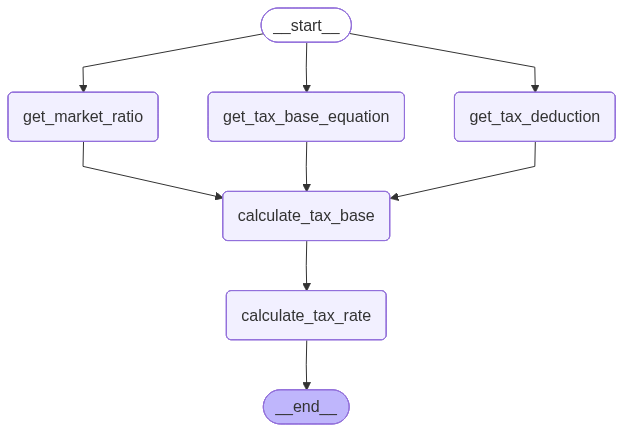

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
initial_state = {'query': query}
graph.invoke(initial_state)

tax_base == 주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.

1. 사용자가 소유한 주택의 공시가격 합계:
   - 5억 + 10억 + 20억 = 35억 원

2. 공제금액:
   - 1세대 1주택자가 아니므로 공제금액은 9억 원입니다.

3. 공정시장가액비율:
   - 2026년의 공정시장가액비율은 60%입니다.

과세표준을 계산하면 다음과 같습니다:

과세표준 = (공시가격 합 - 공제금액) x 공정시장가액비율
과세표준 = (35억 - 9억) x 0.6
과세표준 = 26억 x 0.6
과세표준 = 15.6억 원

따라서, 사용자의 과세표준은 15.6억 원입니다.
tax_rate == 사용자가 3채의 주택을 소유하고 있는 경우, 3주택 이상 소유자의 세율을 적용받게 됩니다. 과세표준이 15.6억 원인 경우에 대한 종합부동산세를 계산해 보겠습니다.

3주택 이상 소유자가 적용받는 세율을 보면:
- 12억 원 초과 25억 원 이하: 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)

과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은:
15.6억 원 - 12억 원 = 3.6억 원

따라서, 초과 금액에 대한 세금은:
3.6억 원 x (1천분의 20) = 720만 원

기본 세금에 초과분 세금을 더하면:
960만 원 + 720만 원 = 1,680만 원

따라서 사용자가 내야 할 종합부동산세는 1,680만 원입니다.


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '사용자가 3채의 주택을 소유하고 있는 경우, 3주택 이상 소유자의 세율을 적용받게 됩니다. 과세표준이 15.6억 원인 경우에 대한 종합부동산세를 계산해 보겠습니다.\n\n3주택 이상 소유자가 적용받는 세율을 보면:\n- 12억 원 초과 25억 원 이하: 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)\n\n과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은:\n15.6억 원 - 12억 원 = 3.6억 원\n\n따라서, 초과 금액에 대한 세금은:\n3.6억 원 x (1천분의 20) = 720만 원\n\n기본 세금에 초과분 세금을 더하면:\n960만 원 + 720만 원 = 1,680만 원\n\n따라서 사용자가 내야 할 종합부동산세는 1,680만 원입니다.',
 'tax_base_equation': '과세표준 = (공시가격 합 - 공제금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 1세대 1주택자는 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그 외의 경우는 9억 원을 공제받습니다.',
 'market_ratio': '2026년의 주택 공시가격에 적용되는 공정시장가액비율은 60%입니다. 2025년부터 한시적으로 낮췄던 비율을 종료하고, 법정 수준인 60%로 되돌린다고 합니다.',
 'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다.\n\n1. 사용자가 소유한 주택의 공시가격 합계:\n   - 5억 + 10억 + 20억 = 35억 원\n\n2. 공제금액:\n   - 1세대 1주택자가 아니므로 공제금액은 9억 원입니다.\n\n3. 공정시장가액비율:\n   - 2026년의 공정시장가액비율은 60%입니다.\n\n과세표준을 계산하면 다음과 같습니다:\n\n과세표준 = (공시가격 합 - 공제금액) x 공정시장가액비율\n과세표준